In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import random

## Multi-Head Attention
The Multi-Head Attention mechanism computes the attention between each pair of positions in a sequence. It consists of multiple “attention heads” that capture different aspects of the input sequence.



In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

## Encoding Layer

An Encoder layer consists of a Multi-Head Attention layer, a Position-wise Feed-Forward layer, and two Layer Normalization layers.

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
   

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

## Decoder Layer
A Decoder layer consists of two Multi-Head Attention layers, a Position-wise Feed-Forward layer, and three Layer Normalization layers.

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

## Transformer Model

In [7]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

## Preparing Sample Data

In [12]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

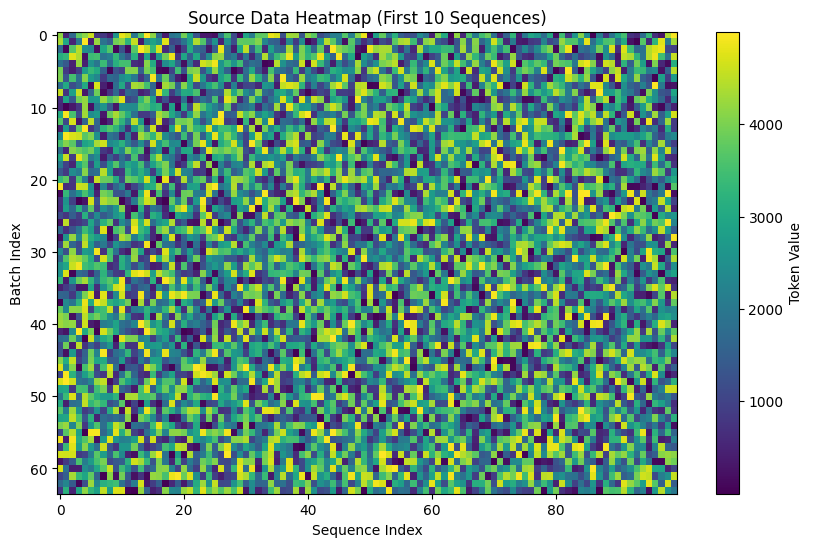

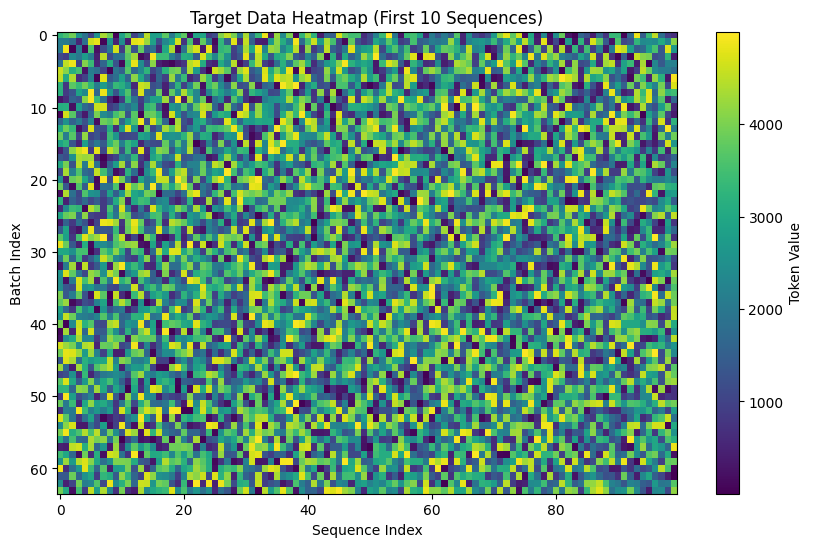

In [17]:
import matplotlib.pyplot as plt
def visualize_data_heatmap(data, title):
    plt.figure(figsize=(10, 6))
    plt.imshow(data.numpy(), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Token Value")
    plt.title(title)
    plt.xlabel("Sequence Index")
    plt.ylabel("Batch Index")
    plt.show()

# Plot source data heatmap
visualize_data_heatmap(src_data[:100], "Source Data Heatmap (First 10 Sequences)")

# Plot target data heatmap
visualize_data_heatmap(tgt_data[:100], "Target Data Heatmap (First 10 Sequences)")

## Traning Model

In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(10):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.674159049987793
Epoch: 2, Loss: 8.542996406555176
Epoch: 3, Loss: 8.469620704650879
Epoch: 4, Loss: 8.419516563415527
Epoch: 5, Loss: 8.364398002624512
Epoch: 6, Loss: 8.295907020568848
Epoch: 7, Loss: 8.225197792053223
Epoch: 8, Loss: 8.142561912536621
Epoch: 9, Loss: 8.05964183807373
Epoch: 10, Loss: 7.979301452636719


In [11]:
transformer.eval()
output = transformer(src_data[:1,:], tgt_data[:1, :-1])
output.view(-1,tgt_vocab_size).argmax(1)


tensor([  28,  442, 3974, 4074, 1661, 2744, 4488, 4488, 4372, 3351, 4782, 3301,
        1746, 1350, 1661, 2454,  765,  765, 3840, 3954, 4051, 1440, 1742, 3504,
        4488, 4744, 3742, 4889, 2678, 3935, 1367, 4901, 4705, 3543, 4086, 4020,
        3554, 3532, 2504, 4338, 1165, 1410, 1616, 4714, 3532, 4522, 1801, 2678,
        4263, 1801, 4914, 2809, 3090,  602, 2917, 2967, 4522, 1232, 1232, 2190,
        3001, 4516,  369, 1868, 1899, 3366, 2143,  607,  680,  919, 4963, 1523,
        1114,  374,  612, 3670,  744, 2550, 4188, 4086,  850, 1875, 1545,  115,
        2607, 2624, 4217, 3158, 1371, 4417,  354, 2426, 4655,  635, 3734, 1625,
        2048, 2726, 4086])

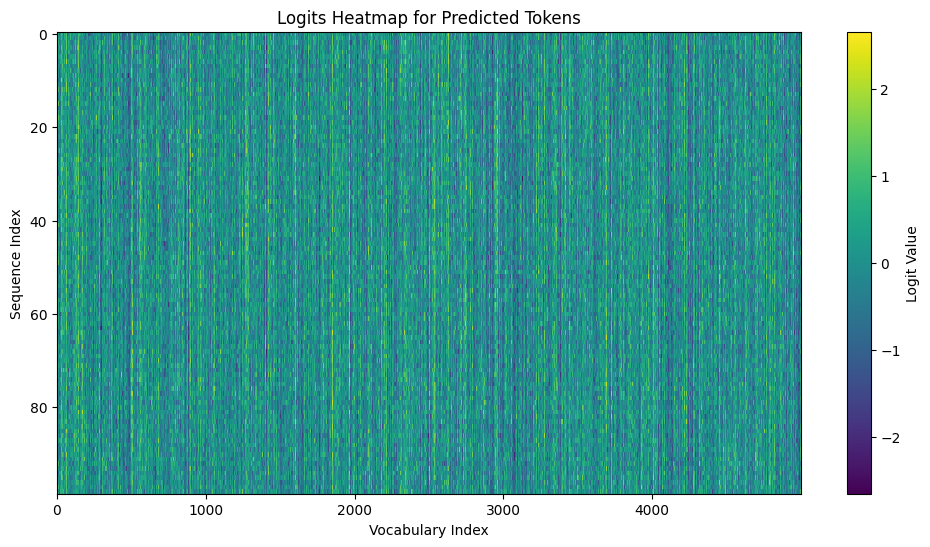


Comparison of Tokens:
    Source Tokens  Target Tokens Predicted Tokens
0            4154           3279             3249
1             513           3566             4798
2            1731           3919             2338
3            3784           2593             3174
4            4144           1913              328
..            ...            ...              ...
95           3342           3384             1246
96            673           4511             4340
97            269           1801             2985
98           4392            881             4643
99           4947            670            <pad>

[100 rows x 3 columns]


,Source Tokens,Target Tokens,Predicted Tokens
0,4154,3279,3249
1,513,3566,4798
2,1731,3919,2338
3,3784,2593,3174
4,4144,1913,328
...,...,...,...
95,3342,3384,1246
96,673,4511,4340
97,269,1801,2985
98,4392,881,4643


In [20]:
import pandas as pd
transformer.eval()
with torch.no_grad():
    # Generate the output logits for the first sample
    output = transformer(src_data[:1, :], tgt_data[:1, :-1])
    logits = output.view(-1, tgt_vocab_size)  # Flatten the output
    predictions = logits.argmax(1)  # Get the predicted token IDs

# Step 2: Visualize the logits as a heatmap
def visualize_logits(logits, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(logits.numpy(), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Logit Value")
    plt.title(title)
    plt.xlabel("Vocabulary Index")
    plt.ylabel("Sequence Index")
    plt.show()

# Plot the logits for the first sample
visualize_logits(logits, "Logits Heatmap for Predicted Tokens")

# Step 3: Compare source, target, and predicted tokens
def compare_tokens(src, tgt, pred, vocab=None):
    # Convert token IDs to human-readable format if a vocabulary is provided
    if vocab:
        src = [vocab.itos[token] for token in src]
        tgt = [vocab.itos[token] for token in tgt]
        pred = [vocab.itos[token] for token in pred]

    # Align the lengths of src, tgt, and pred
    max_len = max(len(src), len(tgt), len(pred))
    src = src[:max_len] + ["<pad>"] * (max_len - len(src))
    tgt = tgt[:max_len] + ["<pad>"] * (max_len - len(tgt))
    pred = pred[:max_len] + ["<pad>"] * (max_len - len(pred))

    # Prepare the data for display
    comparison_df = pd.DataFrame({
        "Source Tokens": src,
        "Target Tokens": tgt,
        "Predicted Tokens": pred
    })

    # Print and return the comparison DataFrame
    print("\nComparison of Tokens:")
    print(comparison_df.head(max_len))
    return comparison_df

# Compare tokens for the first sample
compare_tokens(
    src_data[0].tolist(),
    tgt_data[0].tolist(),
    predictions.tolist()
)